# Problem Set 5
## MACS 30150, Dr. Evans
### Yongfei Lu  , Feb. 8th, 2020

In [2]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as intgr


## Problem 1
### (a)

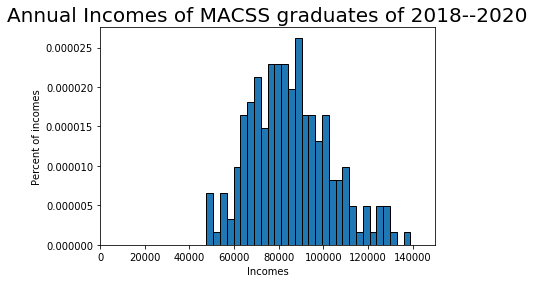

In [16]:
# load the data
pts = np.loadtxt('data/incomes.txt')

# plot the histogram of incomes
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS graduates of 2018--2020',fontsize=20)
plt.xlabel('Incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000])
plt.show()

### (b)

In [12]:
# Define function that generates values of a normal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_lb == 'None' and cut_ub == 'None':
        prob_notcut = 0
    elif cut_lb != 'None' and cut_ub == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    elif cut_lb == 'None' and cut_ub != 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu))
    elif cut_lb != 'None' and cut_ub != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu)) -
                      sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu)))
    
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi))
                * np.exp( -(np.log(xvals) - mu) ** 2 / (2 * sigma **2))) /
                prob_notcut)
    
    return pdf_vals


def data_moments(xvals):
    return xvals.mean(), xvals.std()

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x : x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    mean_model, m_m_err = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x : ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    var_model, v_m_err = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val



In [14]:
# Let's start with the identity matrix as our estimate for the optimal weighting matrix $W = I$
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0.0, 150000.0, W_hat)
res = opt.minimize(criterion, params_init, args=(gmm_args),
                  tol=1e-13, method='L-BFGS-B', bounds=((None, None),(1e-10, None)))
mu_GMM1, sig_GMM1 = res.x
mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM1,sig_GMM1, 0.0, 150000.0)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('mu_GMM =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)
print('GMM Criterion Function:', res.fun)
print('Mean of data:', mean_data, ' Standard Deviation of data:', std_data)
print('Mean of model:', mean_model, ' Standard Deviation of model:', std_model)
print('Error vector =', err1)
res

mu_GMM = 11.333599613401052  sig_GMM1 = 0.2132552950928067
GMM Criterion Function: [[6.39928276e-16]]
Mean of data: 85276.82360625811  Standard Deviation of data: 17992.542128046523
Mean of model: 85276.82405854747  Standard Deviation of model: 17992.541683009
Error vector = [ 5.3037782e-09 -2.4734555e-08]


      fun: array([[6.39928276e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14974807e-08, -2.93649591e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


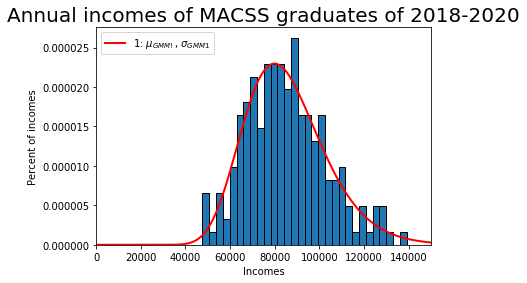

In [15]:
# plot the pdf and histogram
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS graduates of 2018-2020', fontsize=20)
plt.xlabel('Incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000.0),
        linewidth=2, color='r', label='1: $\mu_{GMM!}$, $\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()



### (c)

In [17]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R,N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_data) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat


In [18]:
Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1/pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[4.45167060e-02 1.68385297e+03]
 [1.68385297e+03 9.54184437e+08]]
[[ 2.40701670e+01 -4.24767168e-05]
 [-4.24767168e-05  1.12297424e-09]]


In [22]:
gmm_args = (pts, 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
res2 = opt.minimize(criterion, params_init, args = (gmm_args), tol=1e-14,
                   method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = res2.x
print('mu_GMM2 =', mu_GMM2, ' sig_GMM2 =', sig_GMM2)
print('GMM criterion function:',res2.fun)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of data =', mean_data, ', Standard Deviation of data =', std_data)
print('Mean of model 2 =', mean_model2, ', Standard Deviation of model 2 =', std_model2)
print('Error vector=', err2)

mu_GMM2 = 11.333599603618694  sig_GMM2 = 0.21325529447620906
GMM criterion function: [[4.28528536e-16]]
Mean of data = 85276.82360625811 , Standard Deviation of data = 17992.542128046523
Mean of model 2 = 85276.8232464362 , Standard Deviation of model 2 = 17992.541506074136
Error vector= [-4.21945734e-09 -3.45683441e-08]


/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


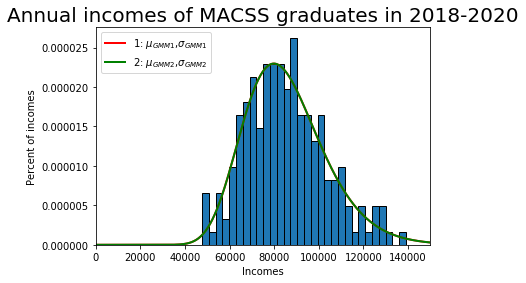

In [25]:
# plot the histogram and pdf of GMM1 and GMM2
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS graduates in 2018-2020', fontsize=20) 
plt.xlabel('Incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000])

# GMM1
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000.0),
        linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
#GMM2
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000.0),
        linewidth=2, color='g', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')

plt.legend(loc='upper left')
plt.show()

### (d)

In [29]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = xvals[(xvals >= 75000) & (xvals <= 100000)].shape[0] / xvals.shape[0]
    bpct_3_dat = xvals[xvals > 100000].shape[0] / xvals.shape[0]
    
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    bpct_1_mod, bp_1_err = intgr.quad(xfx, 0.0, 75000)
    bpct_2_mod, bp_2_err = intgr.quad(xfx, 75000, 100000)
    bpct_3_mod, bp_3_err = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val
 

In [36]:
# estimate the lognormal PDF to fit the data by GMM
W_hat1_3 = np.eye(3)
gmm_args = (pts, 0.0, 150000.0, W_hat1_3)
res3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                   method='L-BFGS-B', bounds=((1e-10, None),(1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = res3.x
print('mu_GMM1_3 =', mu_GMM1_3, ' sig_GMM1_3 =', sig_GMM1_3)
print('GMM criterion function:',res3.fun)
err3 = err_vec3(pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)
print('Error vector:', err3)

bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
pert1, pert2, pert3 = model_moments3(mu_GMM3, sig_GMM1_3, 0.0, 150000.0)
bpct = np.array([bpct_1_dat, bpct_2_dat, bpct_3_dat])
pert = np.array([pert1, pert2, pert3])
df = pd.DataFrame({'Data Moments': bpct, 'Model Moments':pert},
                 index = ['Percent <75000','Percent 75000~100000','Percent >=100000'])

df

mu_GMM1_3 = 11.336705179923449  sig_GMM1_3 = 0.21151351610769975
GMM criterion function: [[2.44369978e-15]]
Error vector: [ 1.13768317e-08  1.18261299e-08 -4.66305708e-08]


,Data Moments,Model Moments
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent >=100000,0.2,0.2


/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


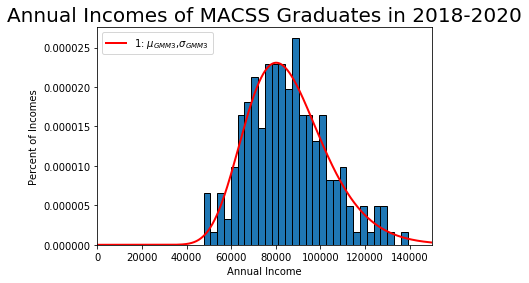

In [44]:
# plot the GMM PDF against the histogram 

num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates in 2018-2020', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0),
        linewidth=2, color='r', label = '1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')
plt.show()

### (e)

In [45]:
def get_Err_mat3(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [51]:
Err_mat3 = get_Err_mat3(pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3 = (1 / pts.shape[0]) * (Err_mat3 @ Err_mat3.T)
print('VCV2_3:\n',VCV2_3)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print('W_hat2_3:\n', W_hat2_3)


VCV2_3:
 [[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
W_hat2_3:
 [[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [59]:
gmm_args = (pts, 0.0, 150000.0, W_hat2_3)
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
res4 = opt.minimize(criterion3, params_init, args=(gmm_args),
                   method='L-BFGS-B', bounds=((1e-10, None),(1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = res4.x
print('mu_GMM2_3 = ', mu_GMM2_3, ' sig_GMM2_3 = ', sig_GMM2_3)
err3 = err_vec3(pts, mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0)

print('Error vector = ', err3)
print('GMM criterion function:',res4.fun)

bpct = np.array([bpct_1_dat, bpct_2_dat, bpct_3_dat])
pert = np.array([pert1, pert2, pert3])
df1 = pd.DataFrame({'Data Moments': bpct, 'Model Moments': pert},
                  index = ['Percent <75000','Percent 75000~100000','Percent > = 100000']).astype(float)
df1

mu_GMM2_3 =  11.336705179923449  sig_GMM2_3 =  0.21151351610769975
Error vector =  [ 1.13768317e-08  1.18261299e-08 -4.66305708e-08]
GMM criterion function: [[5.43640343e-16]]


,Data Moments,Model Moments
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent > = 100000,0.2,0.2


/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/luyongfei/Desktop/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


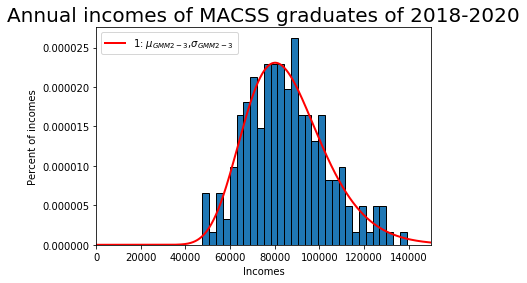

In [57]:
# plot
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS graduates of 2018-2020', fontsize=20) 
plt.xlabel('Incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 0.0, 150000),
         linewidth = 2, color = 'r', label = '1: $\mu_{GMM2-3}$,$\sigma_{GMM2-3}$')
plt.legend(loc = 'upper left')
plt.show()

### (f)

In [63]:
mus=[mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM2_3]
sigs=[sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM2_3]
GMMV=[res.fun,res2.fun,res3.fun,res4.fun]

pd.DataFrame({"mu":mus,"sigma":sigs,"GMM Fn Value":GMMV}
            ,index=['2 moments & Identity Matrix','2 moments & Weighting Matrix',
                   '3 moments & Identity Matrix','3 moments & Weighting Matrix']).astype(float)



,mu,sigma,GMM Fn Value
2 moments & Identity Matrix,11.333600,0.213255,6.399283e-16
2 moments & Weighting Matrix,11.333600,0.213255,4.285285e-16
3 moments & Identity Matrix,11.336705,0.211514,2.443700e-15
3 moments & Weighting Matrix,11.336705,0.211514,5.436403e-16


The best fitting model is the one from (c) as it has the smallest minimized GMM function value. This model uses the average and standard deviation of income as two moments with two-step optimal weighting matrix.

## Problem 2

In [64]:
df = pd.read_csv('data/sick.txt').astype('float64')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [69]:
def err_vec_ln(df, b0, b1, b2, b3):
    yhat = b0 + b1 * df.age + b2 * df.children + b3 * df.avgtemp_winter
    y = df.sick
    return yhat - y

def crit(params, *args):
    b0, b1, b2, b3 = params
    df, W = args
    err = err_vec_ln(df, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

params_init = np.array([1, 0, 0, 0])
W_hat = np.eye(df.shape[0])
gmm_args = (df, W_hat)
res = opt.minimize(crit, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = res.x
b0, b1, b2, b3 = res.x
print("b0=", b0)
print("b1=", b1)
print("b2=", b2)
print("b3=", b3)
print('GMM criterion function:', res.fun)
res

b0= 0.2516448636180223
b1= 0.012933469667256711
b2= 0.40050098511048643
b3= -0.009991708483433188
GMM criterion function: 0.00182128980560192


      fun: 0.00182128980560192
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.24152248e-07, -7.29841534e-07, -8.86870872e-06,  9.29985255e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 235
      nit: 14
   status: 0
  success: True
        x: array([ 0.25164486,  0.01293347,  0.40050099, -0.00999171])